# Statistical Methods for Machine Learning project

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

import math

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [2]:
if 'google.colab' in str(get_ipython()):
    COLAB = True
else:
    COLAB = False

In [3]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
print("Path to dataset files:", path)

100%|██████████| 306M/306M [00:14<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


(200, 300, 3)


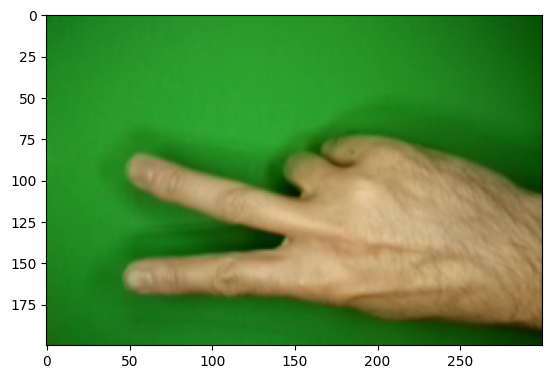

In [4]:
plt.figure()
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
img = io.imread(os.path.join(folder,img_name))
print( img.shape)
plt.imshow(img)
plt.show()

In [5]:
# creation of training and validation folders
ratio = 0.8
subfolders = ['rock','paper','scissors']

os.makedirs('train', exist_ok=True)
os.makedirs('val', exist_ok=True)
for subfolder in subfolders:
    subpath = os.path.join(path, subfolder)
    os.makedirs(os.path.join('train',subfolder))
    os.makedirs(os.path.join('val',subfolder))

    imgs = os.listdir(subpath)
    random.shuffle(imgs)

    train_size = int(0.8 * len(imgs))
    val_size = len(imgs) - train_size

    train_imgs = imgs[:train_size]
    val_imgs = imgs[train_size:]

    for i in train_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('train',subfolder,i))
    for i in val_imgs:
        shutil.copy(os.path.join(subpath,i), os.path.join('val',subfolder,i))




# Transformation and data augmentation

In [6]:
# no need to resize since all images have the same dimension (?)
# validation set only transformed to tensor
# training set augmented with random transformations

val_transform = transforms.Compose([
    transforms.ToTensor()
])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=(-20,20)),
])

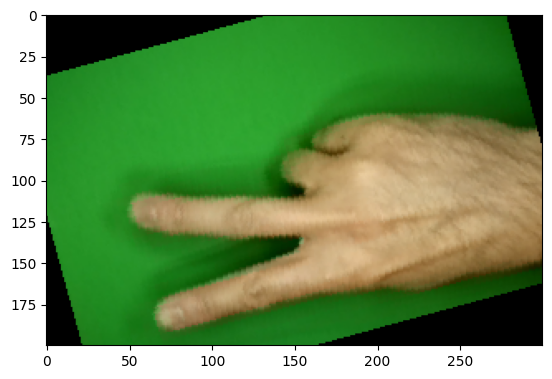

In [7]:
transformed_img = train_transform(img)
plt.imshow(transformed_img.permute(1,2,0))
plt.show()

# DataLoader creation

In [10]:
batch_size = 9
train_dataset = datasets.ImageFolder(root='train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='val', transform=val_transform)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

classes = train_dataset.classes

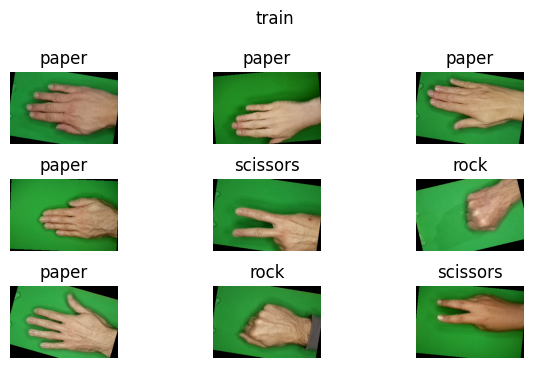

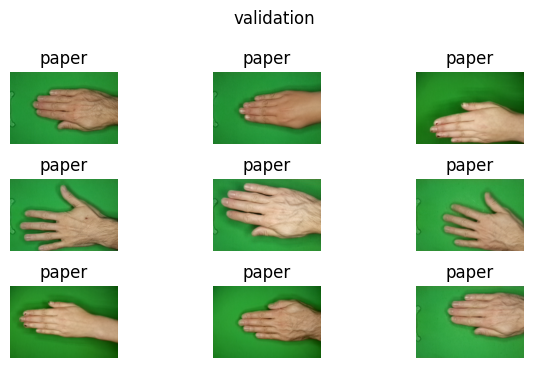

In [11]:
#batch_size = 9

#dataset = datasets.ImageFolder(root=path)
#train_size = int(0.8 * len(dataset))
#val_size = len(dataset) - train_size
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
#train_dataset.dataset.transform = train_transform
#val_dataset.dataset.transform = val_transform
#train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_dl = DataLoader(val_dataset, batch_size=batch_size)

def show_batch(dl, title=None):
    img, lbl = next(iter(dl))
    col = math.floor(math.sqrt(len(img)))
    row = col+1
    for i in range(len(img)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        ax.set_title(classes[lbl[i]])
        ax.axis('off')
        plt.imshow(img[i].permute(1,2,0))
    if (title):
        plt.subplots_adjust(top=0.85)
        plt.suptitle(title)
    plt.show()

show_batch(train_dl, 'train')
show_batch(val_dl, 'validation')

# SomeNet

In [12]:
class SomeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6,16,3)
        self.middleconv2 = nn.Conv2d(16,16,3)
        self.norm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16,64,3)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64,120,3)
        self.middleconv4 = nn.Conv2d(120,120,3)
        self.norm4 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(162*10*10,120)
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(F.relu(self.norm2(self.middleconv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.middleconv4(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = SomeNet()
net.to(device)

img,lbl=next(iter(train_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)
    print('Size of the output tensor is {}'.format(outputs.shape))

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])
Size of the output tensor is torch.Size([9, 3])


In [14]:
#train_model parameters are the network (model), the criterion (loss),
# the optimizer, a learning scheduler (una estrategia de lr strategy), and the training epochs
def train_model(model, dataloaders, classes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    numClasses = len(classes)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 1000000
    best_aucs = np.array([best_auc, best_auc])

    train_loss_time = []
    val_loss_time = []

    best_epoch = -1

    #Loop of epochs (each iteration involves train and val datasets)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)



        # Cada época tiene entrenamiento y validación
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set the model in training mode
            else:
                model.eval()   # Set the model in val mode (no grads)


            #Dataset size
            numSamples = dataset_sizes[phase]

            # Create variables to store outputs and labels
            outputs_m=np.zeros((numSamples,numClasses),dtype=float)
            labels_m=np.zeros((numSamples,),dtype=int)
            running_loss = 0.0

            contSamples=0

            # Iterate (loop of batches)
            for img,lbl in dataloaders[phase]:
                inputs = img.to(device).float()
                labels = lbl.to(device)


                # Set grads to zero
                optimizer.zero_grad()

                # Forward
                # Register ops only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward & parameters update only in train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Accumulate the running loss
                running_loss += loss.item() * inputs.size(0)

                #Apply a softmax to the output
                outputs=F.softmax(outputs.data,dim=1)
                # Store outputs and labels
                outputs_m [contSamples:contSamples+batch_size,...]=outputs.cpu().numpy()
                labels_m [contSamples:contSamples+batch_size]=labels.cpu().numpy()
                contSamples+=batch_size

            #At the end of an epoch, update the lr scheduler
            if phase == 'train':
                scheduler.step()

            #Accumulated loss by epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'train':
                train_loss_time.append(epoch_loss)
            else:
                val_loss_time.append(epoch_loss)

            #Compute the AUCs at the end of the epoch
            aucs=np.array([epoch_loss,epoch_loss])#computeAUCs(outputs_m,labels_m)

            #And the Average AUC
            epoch_auc = aucs.mean()

            print('{} Loss: {:.4f} AUC mel: {:.4f} sk: {:.4f} avg: {:.4f}'.format(
                phase, epoch_loss, aucs[0], aucs[1], epoch_auc))

            # Deep copy of the best model
            if phase == 'val' and epoch_auc < best_auc:
                best_auc = epoch_auc
                best_aucs = aucs.copy()
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best model in epoch {:d} val AUCs: mel {:4f} sk {:4f} avg {:4f}'.format(best_epoch,best_aucs[0],best_aucs[1],best_auc))

    plt.plot(train_loss_time, 'bo-', label='train loss')
    plt.plot(val_loss_time, 'r+-', label='val loss')
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/19
----------
train Loss: 0.0586 AUC mel: 0.0586 sk: 0.0586 avg: 0.0586
val Loss: 1.7514 AUC mel: 1.7514 sk: 1.7514 avg: 1.7514

Epoch 1/19
----------
train Loss: 0.0572 AUC mel: 0.0572 sk: 0.0572 avg: 0.0572
val Loss: 0.0788 AUC mel: 0.0788 sk: 0.0788 avg: 0.0788

Epoch 2/19
----------
train Loss: 0.0217 AUC mel: 0.0217 sk: 0.0217 avg: 0.0217
val Loss: 0.1700 AUC mel: 0.1700 sk: 0.1700 avg: 0.1700

Epoch 3/19
----------
train Loss: 0.0462 AUC mel: 0.0462 sk: 0.0462 avg: 0.0462
val Loss: 0.0615 AUC mel: 0.0615 sk: 0.0615 avg: 0.0615

Epoch 4/19
----------
train Loss: 0.0550 AUC mel: 0.0550 sk: 0.0550 avg: 0.0550
val Loss: 0.0483 AUC mel: 0.0483 sk: 0.0483 avg: 0.0483

Epoch 5/19
----------
train Loss: 0.0255 AUC mel: 0.0255 sk: 0.0255 avg: 0.0255
val Loss: 0.0628 AUC mel: 0.0628 sk: 0.0628 avg: 0.0628

Epoch 6/19
----------
train Loss: 0.0284 AUC mel: 0.0284 sk: 0.0284 avg: 0.0284
val Loss: 0.0702 AUC mel: 0.0702 sk: 0.0702 avg: 0.0702

Epoch 7/19
----------
train Loss: 0.0143 

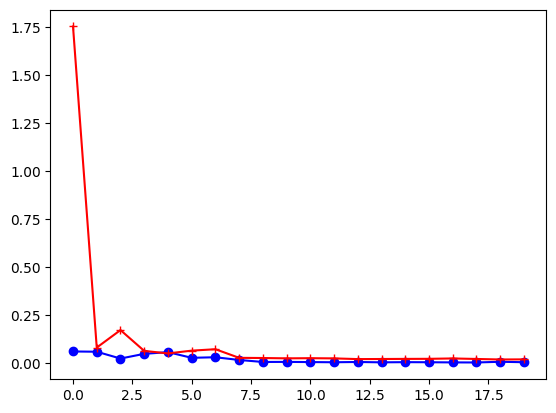

In [22]:
#Loss function
criterion = nn.CrossEntropyLoss()

# SGD with momentum
#optimizer_ft = optim.SGD(customNet.parameters(), lr=1e-3, momentum=0.9)
optimizer_ft = optim.Adam(net.parameters(), lr=1e-3) # Adam seems a better option
# An lr strategy which decreases lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


image_datasets = {'train' : train_dataset, 'val': val_dataset}

dls = {'train' : train_dl, 'val': val_dl}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
net = train_model(net, dls, classes, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Size of tensor containing a batch of images is torch.Size([9, 3, 200, 300])


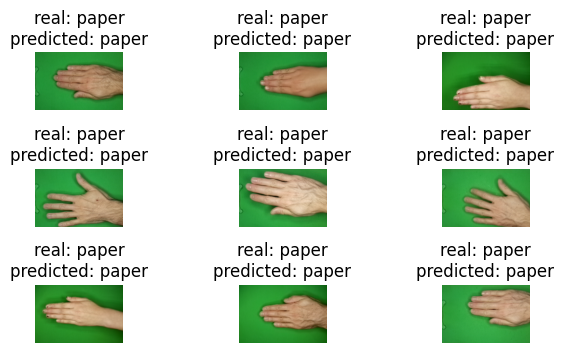

In [23]:
img,lbl=next(iter(val_dl))
inputs = img.to(device).float()
labels = lbl.to(device).float()

print('Size of tensor containing a batch of images is {}'.format(inputs.shape))

#Lo pasamos por la red
with torch.set_grad_enabled(False):
    outputs = net(inputs)

def show_batch2(x, y, yh):
    col = math.floor(math.sqrt(len(x)))
    row = col+1
    for i in range(len(x)):
        ax = plt.subplot(row,col,i+1)
        plt.tight_layout()
        ax.set_title('real: ' + classes[int(y[i])]+'\npredicted: ' + classes[int(np.argmax(yh[i]))])
        ax.axis('off')
        plt.imshow(x[i].permute(1,2,0))
    plt.show()
if (device=='cpu'):
    show_batch2(img,lbl,outputs)
else:
    show_batch2(img,lbl,outputs.cpu().numpy())


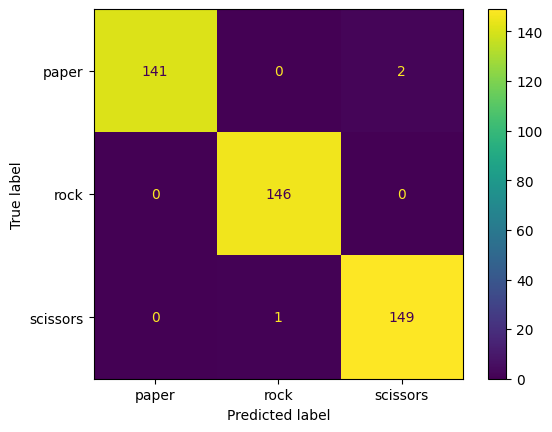

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y = []
y_hat = []

with torch.set_grad_enabled(False):
    for img, lbls in val_dl:
        output = net(img.to(device).float()).to('cpu').float()
        y.extend(lbls)
        pred = output.data.max(1, keepdim=True)[1]
        y_hat.extend(pred)

cm = confusion_matrix(y, y_hat, labels=range(len(classes)))
ConfusionMatrixDisplay(cm,display_labels=classes).plot()

In [ ]:
print(classes)